In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys
import time
import Functions as fun
import seaborn as sns
sns.set_context("paper",font_scale=2)

Let's get everything from previous notebooks:

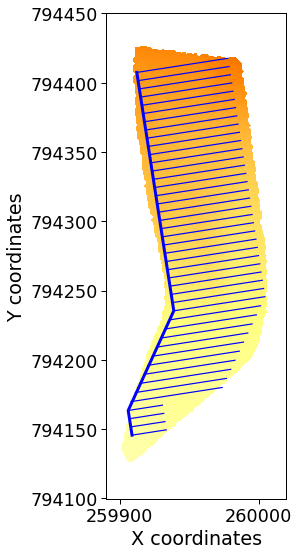

In [2]:
lines = fun.import_lines()
main_line = fun.import_main_line()
fun.plot_map(False, False) # Plotting map
plt.grid(b=False)

for line in lines: # Plotting drip lines
    line = line.reshape(2,2)
    plt.plot(line[:,0],line[:,1],c='blue')

plt.plot(main_line[:,0],main_line[:,1],c='blue',lw=3) # Plotting main line

Now we set the final model to calculate all of the emitter pressure and flow. The parameters are:

### Drip Line Parameters
TifDrip (no pressure compensating) 16/1(1.0 mm)
* Drip space = 0.4 m
* $D_\text{drip}$ = 0.016 m
* $C_\text{drip} = 140$ (Assuming that the material is polyethylen)
* a = 0.999
* x = 0.478

According to 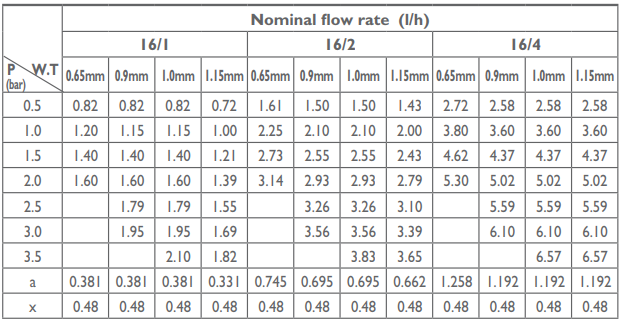

### Main Line Parameters
Lay Flat PVC (SF55)
* $D_\text{main}$ = 0.0381 m
* $C_\text{main} = 150$ (PVC)

According to 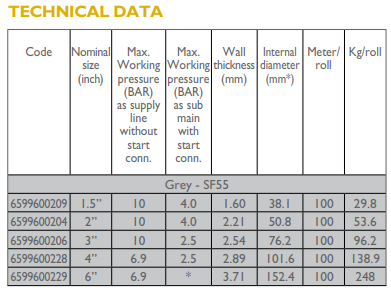

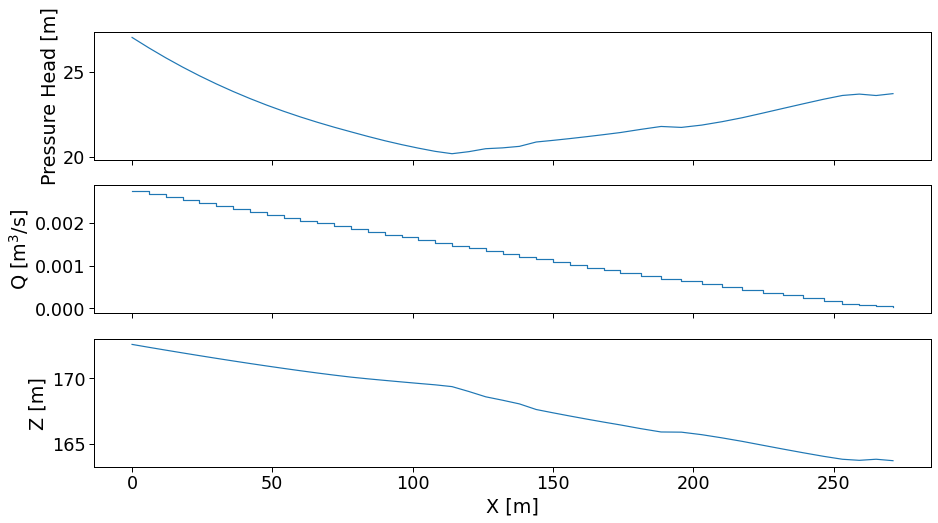

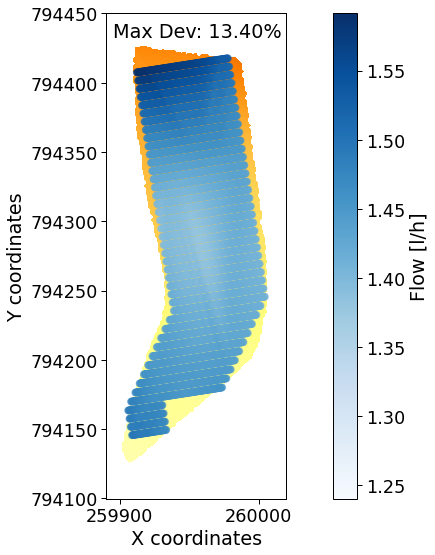

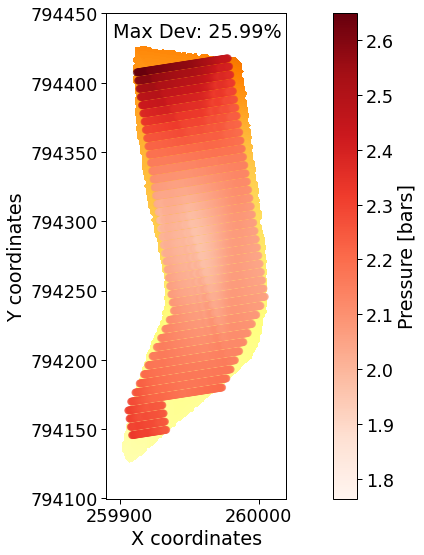

In [3]:
s = fun.System(lines,
               C_main=150,
               D_main=np.repeat(0.0381,43),
               C_drip=140,
               D_drip=0.016,
               space_drip=0.4,
               a=0.999,
               x=0.478)
s.estimate(27)
s.plot_main_profile()
plt.savefig('Figures/WholeSystem1/Profiles.png',bbox_inches='tight')
s.plot_emitters('q')
plt.savefig('Figures/WholeSystem1/q.png',bbox_inches='tight')
s.plot_emitters('p')
plt.savefig('Figures/WholeSystem1/p.png',bbox_inches='tight')

## Diameters Combination

Let's try to apply a bigger diameter to the first 120 meters of the main line (20 first segments).

In [ ]:
n = 20
s = fun.System(lines,
               C_main=150,
               D_main=np.append(np.repeat(0.0508,n),
                                np.repeat(0.0381,43-n)),
               C_drip=140,
               D_drip=0.016,
               space_drip=0.4,
               a=0.999,
               x=0.478)
s.estimate(30)
s.plot_main_profile()
s.plot_emitters('q')
s.plot_emitters('p')

The result is much better. Let's find the optimal number of section with the bigger diameter (n):

In [ ]:
def objective(n):
    s = fun.System(lines,
                   C_main=150,
                   D_main=np.append(np.repeat(0.0508,n),
                                    np.repeat(0.0381,43-n)),
                   C_drip=140,
                   D_drip=0.016,
                   space_drip=0.4,
                   a=0.999,
                   x=0.478)
    s.estimate(30)
    data = s.q_emitters
    data_min = np.nanmin(data.values)
    data_max = np.nanmax(data.values)
    return (data_max - data_min) / data_max

bigger_diameter_section_options = np.arange(0,44,1)
score = []
start_time = time.time()
for n in bigger_diameter_section_options:
    # Printing running percentage
    sys.stdout.flush()
    sys.stdout.write('\r')
    sys.stdout.write('Running: {:.0f}%'.format(np.absolute(n/len(bigger_diameter_section_options))*100))
    
    score.append(objective(n))
end_time = time.time()

In [ ]:
print('{:.0f} seconds'.format(end_time - start_time))

In [ ]:
plt.plot(bigger_diameter_section_options,score,zorder=0)
plt.ylabel('Maximum Deviation')
plt.xlabel('Number of segments with bigger diameter')
n_opt, score_opt = bigger_diameter_section_options[np.argmin(score)], score[np.argmin(score)]
plt.scatter(n_opt,score_opt,c='red',zorder=1)
plt.text(n_opt-2, score_opt+0.01, n_opt, c='red')

In [ ]:
n = 14
s = fun.System(lines,
               C_main=150,
               D_main=np.append(np.repeat(0.0508,n),
                                np.repeat(0.0381,43-n)),
               C_drip=140,
               D_drip=0.016,
               space_drip=0.4,
               a=0.999,
               x=0.478)
s.estimate(30)
s.plot_main_profile()
s.plot_emitters('q')
s.plot_emitters('p')

## Optimal Initial Pressure and Diameters Combination

Now we want to find the optimal value of

* Initial pressure of the system

* Number of section with the bigger diameter

Where the objective function now returns the absolute mean of the flow difference from 1.5 l/h.

In [ ]:
'''def objective(n, p_init):
    s = fun.System(lines,
                   C_main=150,
                   D_main=np.append(np.repeat(0.0508,n),
                                    np.repeat(0.0381,43-n)),
                   C_drip=140,
                   D_drip=0.016,
                   space_drip=0.4,
                   a=0.999,
                   x=0.478)
    s.estimate(p_init)
    q_emitters = s.q_emitters.values.flatten()
    q_emitters = q_emitters[~np.isnan(q_emitters)]   
    return np.mean(np.absolute(q_emitters-1.5))

import sys

n_range = np.arange(11,18,1)
p_range = np.arange(22,29,1)
n_grid, p_grid = np.meshgrid(n_range, p_range)
score = np.array([])
c=0
start_time = time.time()
for n,p in zip(n_grid.flatten(), p_grid.flatten()):
    # Printing running percentage
    sys.stdout.flush()
    sys.stdout.write('\r')
    sys.stdout.write('Running: {:.0f}%'.format(np.absolute(c/len(p_grid.flatten()))*100))
    c=c+1
    
    score = np.append(score,objective(n,p))

end_time = time.time()
score_grid = score.reshape(n_grid.shape)

np.save('ResponseSurface/score_grid',score_grid)
np.save('ResponseSurface/n_grid',n_grid)
np.save('ResponseSurface/p_grid',p_grid)
print('{:.0f} seconds'.format(end_time - start_time))'''

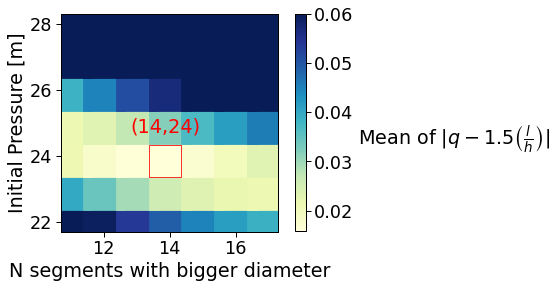

In [16]:
score_grid = np.load('ResponseSurface/score_grid.npy')
n_grid = np.load('ResponseSurface/n_grid.npy')
p_grid = np.load('ResponseSurface/p_grid.npy')

# Optimal values
opt_indices = np.unravel_index(np.argmin(score_grid),score_grid.shape)
n_opt, p_opt = n_grid[opt_indices], p_grid[opt_indices]
score_opt = score_grid[opt_indices]

fig, axis = plt.subplots()
cs_contourf = axis.scatter(n_grid, p_grid,
                           c = score_grid,
                           marker = 's',
                           s=1800,
                           vmax=0.06,
                           cmap='YlGnBu')
axis.grid(b=False)
cbar = fig.colorbar(cs_contourf, ax=axis)
cbar.set_label(r'Mean of $|q-1.5 \left(\frac{l}{h}\right)|$', labelpad=100,rotation=0)
axis.set_ylabel('Initial Pressure [m]')
axis.set_xlabel('N segments with bigger diameter')
axis.scatter(n_opt-0.15, p_opt-0.16, s=1000,marker='s' ,facecolors='none', edgecolors='r')
axis.annotate('({},{})'.format(n_opt, p_opt),
              (n_opt, p_opt), xycoords='data', xytext=(n_opt-1.2, 0.7 + p_opt), c ='red')
axis.set_aspect('equal', 'box')
plt.savefig('Figures/ResponseSurface.png',bbox_inches='tight')

Let's try the optimal values:

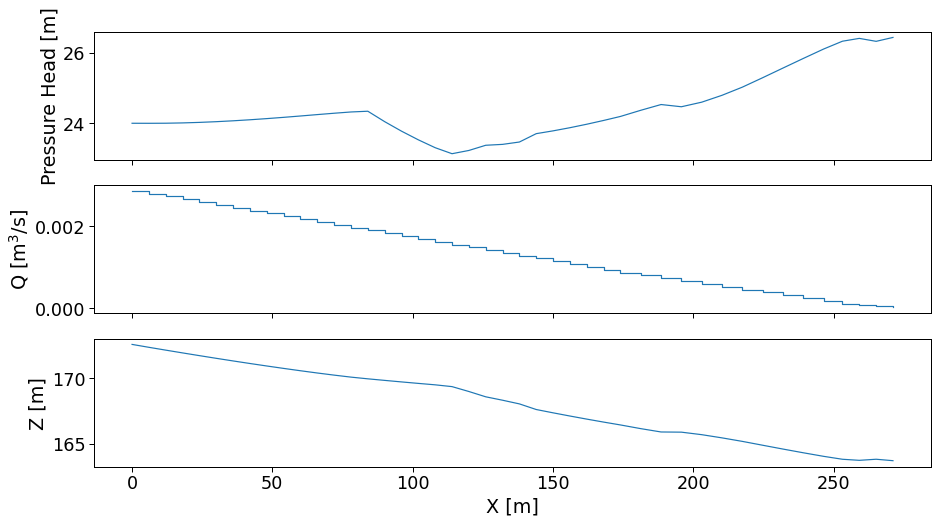

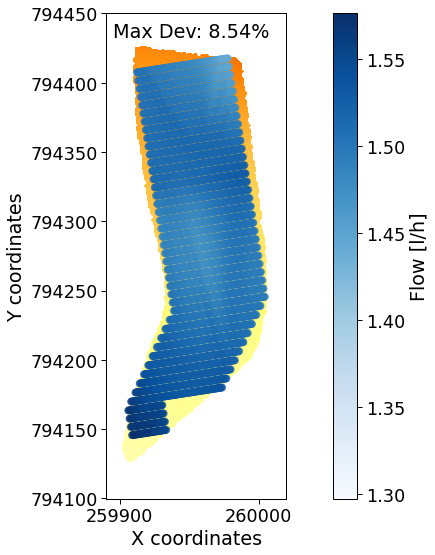

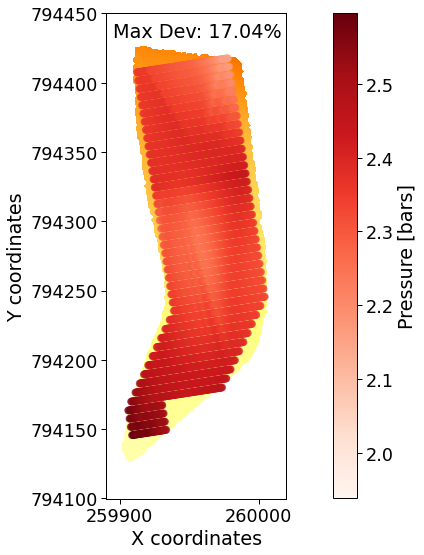

In [5]:
n = 14
p = 24
s = fun.System(lines,
               C_main=150,
               D_main=np.append(np.repeat(0.0508,n),
                                np.repeat(0.0381,43-n)),
               C_drip=140,
               D_drip=0.016,
               space_drip=0.4,
               a=0.999,
               x=0.478)
s.estimate(p)
s.plot_main_profile()
plt.savefig('Figures/WholeSystem2/Profiles.png',bbox_inches='tight')
s.plot_emitters('q')
plt.savefig('Figures/WholeSystem2/q.png',bbox_inches='tight')
s.plot_emitters('p')
plt.savefig('Figures/WholeSystem2/p.png',bbox_inches='tight')

So the result is:
* $14\times6 \text{ m}=84$ m diameter of 50.8 mm
* $272\text{ m} - 84\text{ m} = 188$ m diameter of 38.1 mm
* Initial pressure of 24 m $\rightarrow$ 235.2 kPa $\rightarrow$ 2.352 bar